In [1]:
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


## 💾 La donnée

### De quoi avons-nous besoin ?
Pour mener cette enquête, nous devons constituer les "empreintes digitales" physico-chimiques des produits. Nous avons structuré notre dataset ainsi :

* 🎯 **La Cible (y) :** Le grade **Nutri-Score** (A, B, C, D, E).
* 🧪 **Les Indices (X) :** Les macronutriments bruts (sucre, sel, gras, fibres, protéines, etc.).
* 🏷️ **Le Contexte :** La catégorie du produit (on ne juge pas un fromage comme un soda).

### Source et Fiabilité : Le défi OpenFoodFacts
Nous avons choisi **OpenFoodFacts**, une base de données collaborative. Ce choix méthodologique est à double tranchant :

* ✅ **La Force (Réalisme) :** C'est le reflet du marché réel, pas un dataset aseptisé de laboratoire.
* ⚠️ **La Faiblesse (Bruit) :** C'est un chaos de données (erreurs de saisie, unités hétérogènes, doublons). La fiabilité brute est faible, rendant le **Data Cleaning** plus critique que la modélisation elle-même.

### Une démarche "Frugale" assumée
Nous avons délibérément choisi de ne pas travailler sur l'intégralité de la base (Big Data), mais sur un échantillon représentatif.

1.  **Sobriété Numérique :** Entraîner des modèles sur des millions de lignes pour un gain de précision marginal (0.01%) est un non-sens écologique.
2.  **Méthodologie > Volume :** Nous voulons démontrer qu'un échantillon propre et des *Smart Features* battent toujours un gros volume de données bruité. Cela nous permet de rester agiles et d'itérer rapidement.

---

## 🧹 Nettoyage : Imposer les lois de la physique

La première étape n'a pas été technique, mais **physique**. Pour valider nos ordres de grandeur, nous avons codé des règles immuables :

* ❌ **La règle des 100% :** Un produit ne peut pas contenir 150g de sucre pour 100g de matière. Nous avons supprimé ou "clampé" ces aberrations.
* 🔥 **La cohérence calorique :** Exclusion de tout produit dépassant **900 kcal/100g** (valeur de l'huile pure). Au-delà, c'est une erreur de saisie.

> **🚫 Traitement radical des valeurs manquantes (NaN)**
>
> Nous avons **refusé l'imputation par la moyenne**.
> *Remplacer une valeur manquante par la "moyenne du sucre" n'a aucun sens pour classer un produit réglementaire.*
>
> **Notre choix :** Si l'information manque, le produit est **écarté de l'apprentissage**. C'est une approche stricte, mais nécessaire pour garantir la pureté du modèle.

Enfin, pour la lisibilité, nous avons renommé les colonnes techniques de l'API (ex: `energy-kcal_100g`) en termes humains (`Energie`, `Sucre`), créant ainsi notre propre dictionnaire de variables.

In [2]:
# 1. Charge l'extension d'autorechargement
%load_ext autoreload

# 2. Configure pour tout recharger automatiquement avant chaque exécution
%autoreload 2
from food_analyzer import *

### ⚙️ Stratégie d'aquisition des données

Pour garantir la fiabilité et la reproductibilité du dataset, nous avons implémenté une logique de collecte défensive :

- **Gestion intelligente de l'API (Pagination & Rate-Limiting) :** Nous récupérons les données par lots de 50 produits avec des temporisations (`sleep`) entre les appels.  
  *Pourquoi ?* Cette approche contourne les timeouts serveur, respecte les quotas de l'API OpenFoodFacts et évite le bannissement de notre IP.

- **Détection d'environnement (CI/CD vs Local) :** Le script détecte automatiquement s'il tourne sur GitHub Actions (`IS_CI`).  
  *Pourquoi ?* Cela permet de charger le dernier dataset statique sauvegardé ou échantillonné dans `data/food.csv`, rendant le pipeline d'intégration continue **rapide et déterministe**, sans dépendre de la disponibilité de l'API externe.

- **Tolérance aux pannes :** Intégration de mécanismes de "retry" en cas d'erreur HTTP.  
  *Pourquoi ?* Assure que la constitution du dataset ne s'arrête pas à la moindre micro-coupure réseau, garantissant une collecte complète des 500 produits visés par catégorie.

In [3]:
saved_dataset = True
df_final = downloader(saved_dataset) # Data cleaning encapsulé au sein même de l'étape de téléchargement des données

🌍 Lancement de la collecte
🤖 Utilisation du dataset 
--------------------------------------------------
🚀 DATASET FINAL : 2980 produits.
--------------------------------------------------
Répartition par Catégorie :
Category_Label
Céréales         482
Légumineuses     439
Biscuits         406
Légumes          400
Pizzas           393
Chocolats        336
Jus de Fruits    310
Fromages         214
Name: count, dtype: int64

Répartition par Nutriscore :
Nutriscore
A    669
B    336
C    829
D    601
E    545
Name: count, dtype: int64


### 🥗 Sélection des Catégories

Nous avons délibérément ciblé 8 catégories hétérogènes (des *Légumes* aux *Pizzas* en passant par les *Chocolats*) pour maximiser la représentativité du dataset :

- **Couverture du spectre nutritionnel :** Cette sélection garantit une distribution variée des **Nutriscores (de A à E)** et des groupes **NOVA**, nous permettant de comparer des produits bruts (sains) à des produits ultra-transformés.
- **Variété des attributs :** En mixant boissons, plats préparés, produits secs et frais, nous capturons un large éventail de valeurs nutritionnelles (taux de sucre, gras, protéines), ce qui est indispensable pour éviter les biais d'analyse sur un seul type d'aliment.

Nous pouvons observé que nous avons obtenu un dataset équilibré où les produits de chaque catégorie sont représentés en grand nombre avec un même ordre de grandeur.


### 🧪 Sélection des variables explicatives
Pour garantir la performance du modèle, nous avons retenu un vecteur de **8 variables quantitatives** et **1 variable catégorielle**, divisées en trois groupes stratégiques reflétant la logique officielle du Nutri-Score.

#### 1. Les composantes négatives (pénalisantes pour le nutri-score à priori)
Le Nutri-Score fonctionne par accumulation de "points négatifs" (N). Pour imiter ce comportement, nous avons sélectionné :

* **`nutriments.energy-kcal_100g`** : La densité énergétique est le premier facteur de pénalité.
    * Les variantes en kJ ont été écartées pour éviter la colinéarité parfaite (redondance d'information).
* **`nutriments.sugars_100g`** (Sucres totaux) :
    * L'algorithme actuel sanctionne les sucres totaux. Utiliser les sucres ajoutés (`added-sugars`) aurait induit le modèle en erreur sur les produits naturellement sucrés (ex: jus de fruits).
* **`nutriments.saturated-fat_100g`** (Acides gras saturés) :
    * Nous avons délibérément choisi les graisses saturées et non les graisses totales (`fat_100g`). Un produit peut être gras mais sain (ex: Huile de noix).
* **`nutriments.sodium_100g`**

#### 2. Les composantes Positives (valorisantes pour le nutri-score à priori)
Le score est atténué par des "points positifs" (P). Sans ces variables, le modèle ne peut pas expliquer pourquoi une pizza classée B est meilleure qu'une autre classée D.

* **`nutriments.fiber_100g`** (Fibres)
* **`nutriments.proteins_100g`** (Protéines)
* **`nutriments.fruits-vegetables-nuts-estimate-from-ingredients_100g`** :
    * Variable souvent latente (estimée). Sans elle, le modèle échoue systématiquement à prédire correctement les classes A et B des produits transformés mixtes (plats préparés).

#### 3. La variable de contextualisation

* **`Category_Label`** (Catégorie du produit) :
    * Le calcul du Nutri-Score n'est pas universel (grilles distinctes pour les "Matières grasses", "Boissons" et "Fromages").
    * *Impact ML :* Cette variable permet aux algorithmes non-linéaires (comme le Random Forest) de créer des embranchements conditionnels (ex: *"Si Fromage, alors tolérer plus de gras"*).



#### 🚫 Justification des variables rejetées
L'exclusion de variables est cruciale pour réduire le bruit et garantir la robustesse du modèle.

##### A. Élimination du Bruit (Micronutriments)
Nous avons exclu : `vitamin-c`, `calcium`, `iron`, `magnesium`, etc.
> Bien que vitaux, ces micronutriments n'entrent pas dans la formule du Nutri-Score. Les inclure créerait des corrélations fallacieuses (ex: le modèle associerait "Vitamine C" à "Bon score" uniquement parce que les fruits en contiennent, faussant l'analyse causale).

##### B. Standardisation des Unités (Biais d'échelle)
Nous avons exclu toutes les colonnes `_serving` (par portion) et `_unit`.
> Pour que le Machine Learning soit viable, les données doivent être comparables. Comparer 100g de biscuits à une portion de 30g introduirait un biais mathématique majeur. Nous travaillons exclusivement sur la base normalisée **Standard 100g**.

##### C. Prévention de la Fuite de Données (Data Leakage)
Nous avons exclu : `nutriscore_score` (le score numérique brut).
> C'est la réponse à l'équation (Target). Donner le score numérique au modèle pour prédire la classe (A-E) donnerait une précision artificielle de 100%, mais le modèle n'aurait rien appris sur la composition nutritionnelle réelle.


## 4. Exploration : Les surprises du dataset

On peut observer la distribution des produits par nutriscore avec leurs teneurs pour chaque nutriment.
On voit que le sucre, le gras, la graisse saturée ont l'air d'avoir comme on pouvait l'imaginer, un impact négatif sur le Nutri-score.

Nous vous invitons à consulter le graphe suivant pour Fruits et Légumes pour ainsi découvrir que cette variable à l'air d'être assez déterminante statistiquement pour obtenir un Nutri-score positif A B ou C.

In [4]:
distribution_nutriments_nutriscore(df_final)

🔍 Analyse détaillée par nutriment :


interactive(children=(Dropdown(description='nutriment_choisi', options=('Energie', 'Sucre', 'Gras', 'Saturés',…

**L'exemple du sucre**

**Le schéma suivant montre bien que** la relation entre le taux de sucre et le Nutriscore n'est pas strictement binaire.

En observant la distribution, on constate que si une teneur en sucre > 20g (zone rouge) est *majoritairement* corrélée à un Nutriscore défavorable D ou E, cette règle n'est pas absolue. Des points aberrants (outliers) apparaissent dans des scores plus favorables C, probablement sauvés par leur teneur en Fruit et Légumes.

C'est cette "zone grise" qui nous donne envie d'utiliser un modèle de machine learning particulier, un **Random Forest**. Il est capable de segmenter ces cas limites en appliquant des règles conditionnelles successives pour déterminer comment le Nutriscore arbitre ces compensations nutritionnelles.

In [5]:
impact_matrix_sugar(df_final).show()

La Heatmap ci-dessous nous permet de valider la cohérence nutritionnelle du dataset et d'anticiper les comportements du modèle :

- **Forte multicollinéarité (redondance) :** On observe une corrélation très élevée (**0.86**) entre *Gras* et *Saturés*, ainsi qu'entre *Energie* et *Gras* (**0.83**). Cela est logique (le gras est le macronutriment le plus calorique), mais cela indique que ces variables apportent une information très similaire.
- **L'indépendance du sel :** Le *Sel* est une variable quasi-orthogonale (corrélations proches de 0 partout). C'est une excellente nouvelle : cela signifie qu'il apporte une information unique et complémentaire pour la prédiction.
- **Opposition structurelle :** La corrélation négative entre *Fruits/Légumes* et *Energie* (**-0.61**) confirme que les aliments sains sont structurellement moins denses en calories.

In [6]:
corr_matrix(df_final).show()

La répartition des scores par famille d'aliments confirme la nécessité d'inclure la catégorie comme variable explicative :

* **Polarisation des Catégories :** Certaines familles sont des prédicteurs forts à elles seules.
    * Les *Légumineuses* et *Légumes* sont massivement classés **A ou B** (Vert).
    * Les *Chocolats* et *Biscuits* saturent les classes **D et E** (Rouge/Orange).
* **La Zone Grise (Variance Intra-classe) :** C'est ici que le Machine Learning devient indispensable.
    * Regardez les **Céréales** : elles couvrent tout le spectre, du A au E.
    * Les **Pizzas** et **Jus de Fruits** oscillent principalement entre C et D, mais avec des exceptions notables.
    * *Conclusion :* La catégorie seule ne suffit pas à prédire le score. Le modèle devra analyser la composition fine (fibres, sucres) pour classer correctement ces produits "mixtes".

In [7]:
distribution_nutriscore_par_famille_d_aliments(df_final).show()

Ce graphique en barres empilées montre la répartition des scores pour les marques les plus fréquentes.
* **Marques Spécialistes vs Généralistes :**
    * Les marques de confiserie (Milka, Lindt, Cadbury) sont quasi-exclusivement rouges/oranges.
    * Les marques distributeurs (Carrefour, Marque Repère, Sainsbury's) présentent un profil très varié, reflétant leur catalogue diversifié.
* **Risque de Biais (Data Leakage) :**
    * Si nous utilisions la variable "Marque" pour l'entraînement, le modèle pourrait apprendre paresseusement : *"Si Milka, alors E"*.
    * *Décision :* Nous avons exclu la marque des variables explicatives. Le but est que le modèle juge un produit sur sa **composition nutritionnelle** (le taux de sucre), et non sur son étiquette commerciale. Cela garantit que le modèle pourra noter correctement une nouvelle marque inconnue à l'avenir.

In [8]:
nutriscore_par_marques(df_final).show()

**1. Distribution du Sucre par Score (Boxplot) :**
* **Chevauchement des Classes :** On remarque que le Nutri-Score **D** possède une étendue très vaste (jusqu'à 59.7g de sucre), dépassant largement les médianes des classes supérieures. 
* **La "Bascule" du Score E :** La boîte à moustaches du score **E** commence là où les autres s'arrêtent (médiane à 35g), confirmant que le sucre est un "accélérateur" de mauvaise note, mais qu'il n'est pas le seul critère de discrimination pour les scores intermédiaires.

**2. Cartographie Gras vs Sucre (Scatter Plot) :**
* **Zones de Densité :** Le nuage de points montre une saturation de produits **D (Orange)** et **E (Rouge)** dans les zones à haute teneur en gras (>30g) ou en sucre (>40g).
* **L'Exceptions des "Bons" Scores :** Les produits **A et B** (en vert) sont quasi-exclusivement confinés dans le coin inférieur gauche (faible en gras ET faible en sucre). 
* **Non-Linéarité :** De nombreux produits avec un taux de gras moyen (20-30g) se retrouvent éparpillés entre les scores B, C et D. Cela prouve que des variables "correctrices" (fibres, protéines, pourcentage de fruits) jouent un rôle de balance, empêchant une classification par simple régression.

In [9]:
sucre_gras(df_final)

👇 Change de catégorie pour mettre à jour instantanément :


interactive(children=(Dropdown(description='Filtre :', options=('Toutes', 'Biscuits', 'Chocolats', 'Céréales',…

#### 💡 Conclusion de l'analyse exploratoire des données

L'ensemble de ces visualisations confirme trois points clés pour la suite de notre projet :

1.  **Le Nutriscore est multi-factoriel :** Aucune variable seule (sucre, gras ou calories) ne permet de prédire le score avec certitude. C'est l'interaction entre les bonus (fibres, protéines, fruits) et les malus qui crée la note finale.
2.  **La Catégorie est un pivot :** Un même taux de sucre n'aura pas le même impact sur une céréale que sur un fromage. L'inclusion du `Category_Label` dans notre modèle sera déterminante.
3.  **Le choix du Random Forest est validé :** Face à la forte colinéarité des nutriments et aux seuils de bascule visibles sur les boxplots (ex: le sucre chez les chocolats), un algorithme capable de créer des règles de décision non-linéaires est l'outil idéal.

## 5. 🌲 Modélisation : Expliquer plutôt que prédire

### Notre approche : Classification supervisée
Le problème est traité comme une classification multiclasse (A, B, C, D, E). L'objectif est de rétro-ingénierier la logique mathématique de la notation.

### Le choix de l'arme : Random Forest
Nous avons privilégié la **Forêt Aléatoire** pour trois raisons :
1. **Logique par seuils :** Les arbres de décision imitent parfaitement la structure de règles "Si... Alors..." de l'algorithme officiel.
2. **Résistance à la multicollinéarité :** Le Random Forest gère naturellement les variables corrélées (ex: Énergie vs Gras) identifiées lors de l'EDA.
3. **Interprétabilité :** Grâce au `feature_importance`, nous pouvons quantifier l'impact réel de chaque nutriment sur la note finale.

> **Note sur l'interprétation :** Une attention particulière est portée à la lecture de l'importance des variables, car l'impact des variables colinéaires peut être réparti arbitrairement entre elles.


🟦 --- ÉTAPE 1 : BASELINE SIMPLE ---
👶 Mode BASIC : Utilisation des nutriments bruts.
✅ Dataset prêt : 16 variables en entrée.
📊 CV Score : 86.78% (+/- 1.02%)


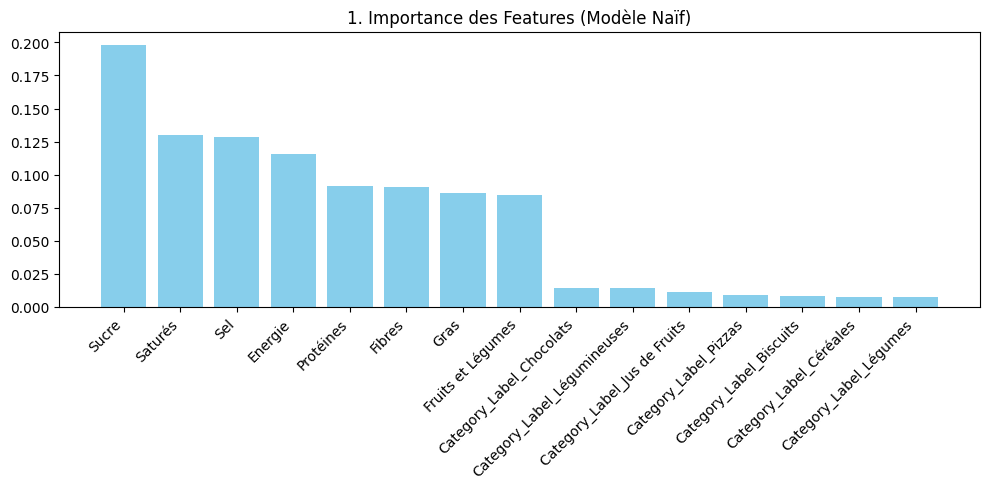

In [10]:
from food_analyzer.predictor import NutriModel
import matplotlib.pyplot as plt

# Initialisation
predictor = NutriModel(df_final)
scores_history = {} 

# 1️⃣ TRAIN / TEST NORMAL (La Baseline)
print("\n🟦 --- ÉTAPE 1 : BASELINE SIMPLE ---")
predictor.prepare_data(include_categorical=True)
predictor.train()
scores_history['1. Baseline'] = predictor.evaluate(method="cross_val")

# 📊 VUE 1 : Comment réfléchit le modèle "naïf" ?
predictor.plot_feature_importance(top_n=15, custom_title="1. Importance des Features (Modèle Naïf)")

L'analyse de l'importance des variables pour le **Modèle Naïf** révèle une hiérarchie claire dans la prédiction du Nutriscore :

#### 1. Variables déterminantes (Impact Majeur)
* **Sucre (~20%)** : Le prédicteur dominant. Une variation du taux de sucre est le facteur le plus susceptible de modifier la classe prédite.
* **Effet Combiné (Gras / Énergie / Saturés)** : Ces trois variables agissent de concert. Bien que l'**Énergie (~11%)** et les **Acides Gras Saturés (~13%)** soient isolés dans le graphique, ils sont intrinsèquement liés aux **Gras (~8%)**, formant un bloc de pénalité cohérent.
* **Sel (~13%)** : Complète le trio des variables "critiques" avec un impact direct et élevé.

#### 2. Variables à impact moyen
* **Protéines & Fibres ** : Impact modéré, agissant comme contrepoids positif (bonus) dans l'algorithme de calcul pour améliorer le score final.
* **Fruits & Légumes** : Moindre influence sur les décisions du modèle, possiblement due à une plus faible variabilité dans le jeu de données.

#### 3. Variables un peu plus faible
L'observation du graphique montre que les variables issues du **One-Hot Encoding** (les labels de catégories de produits) affichent systématiquement un impact plus faible que les variables numériques :

* **Dilution de l'Information** : En transformant une colonne "Catégorie" en plusieurs colonnes binaires (0 ou 1), l'importance statistique est fragmentée. Chaque catégorie individuelle pèse moins lourd que les variables continues comme le Sucre ou l'Énergie.
* **Universalité des nutriments** : Le faible impact des variables catégorielles suggère que le modèle privilégie les **valeurs nutritionnelles intrinsèques** plutôt que l'appartenance à une catégorie spécifique. En clair, le modèle "comprend" qu'un produit est mal classé à cause de son taux de sucre, peu importe qu'il s'agisse d'un soda ou d'un biscuit.
* **Biais de variabilité** : La plupart des catégories encodées sont très spécifiques et ne concernent qu'une petite portion du dataset, ce qui limite leur pouvoir prédictif global par rapport aux nutriments présents dans 100% des produits.


### 📈 Analyse de la Performance (Validation Croisée)

Le modèle affiche un score de **86.78%** avec un écart-type de **+/- 1.02%**.

* **Performance Elevée** : Un score de ~87% indique que le modèle possède une excellente capacité prédictive pour classer correctement les produits selon leur Nutriscore.
* **Grande Stabilité** : L'écart-type très faible (1.02%) prouve que les performances sont consistantes. Le modèle ne dépend pas d'un échantillon de données spécifique et ne présente pas de signe de surapprentissage (overfitting) marqué.
* **Fiabilité** : Cette robustesse statistique confirme que les conclusions tirées sur l'importance des features (Sucre, Énergie, Saturés) s'appuient sur un modèle fiable et généralisable.


### ⚙️ L'Optimisation des Hyperparamètres (Tuning)

L'**Hyperparameter Tuning** consiste à régler manuellement les curseurs d'un modèle pour maximiser ses performances.

* **Paramètres vs Hyperparamètres** : Les paramètres sont appris par le modèle (poids), tandis que les hyperparamètres sont configurés **avant** l'entraînement (ex: profondeur d'un arbre).
* **Objectif** : Trouver le réglage optimal pour éviter le sur-apprentissage (trop complexe) ou le sous-apprentissage (trop simple).
* **Méthodes** : On utilise généralement un **Grid Search** (test de toutes les combinaisons) ou un **Random Search** (test aléatoire) pour identifier la meilleure configuration.

**En résumé** : C'est le passage du réglage "par défaut" au réglage "sur mesure" pour gagner en précision et en stabilité.

Nous testons un GridSearch dans la prochaine cellule.


🟨 --- ÉTAPE 2 : TUNING DU MODÈLE BASELINE ---
🔧 Optimisation en cours (Patience...)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
🎉 Meilleurs params : {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 CV Score : 86.34% (+/- 0.96%)


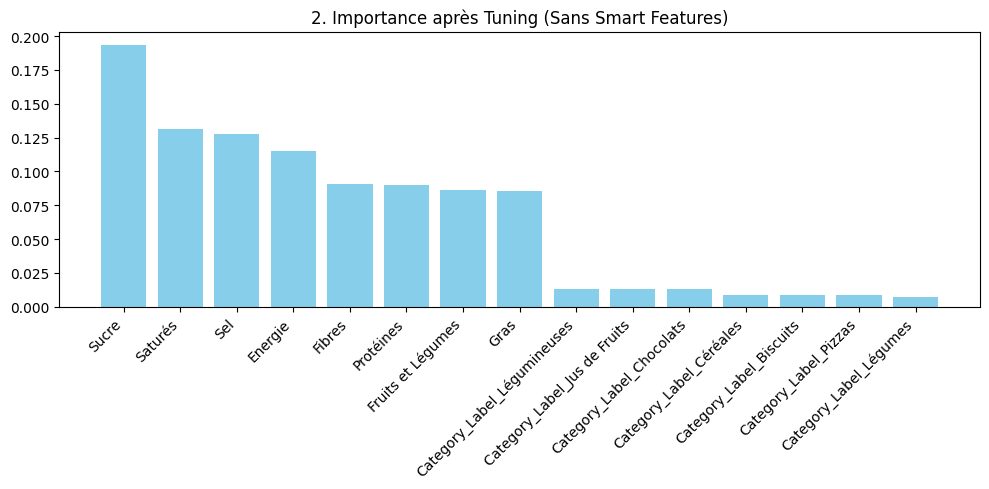

In [11]:
# 1 HYPERPARAMÈTRES (Optimisation du modèle de base)

print("\n🟨 --- ÉTAPE 2 : TUNING DU MODÈLE BASELINE ---")
predictor.optimize_hyperparameters()
scores_history['2. Baseline Tuned'] = predictor.evaluate(method="cross_val")

# 📊 VUE 2 : Est-ce que le tuning change la logique ?
predictor.plot_feature_importance(top_n=15, custom_title="2. Importance après Tuning (Sans Smart Features)")

Le tuning ne change pas vraiment le résultat précédent, c'est pourquoi on a eu l'idée de créer de nouvelles features pour essayer d'avoir une meilleure prédictibilité.

### 🛠️ Le Feature Engineering : L'Intelligence Métier

C'est ici que notre projet se distingue. Pour dépasser le plafond de performance de nos modèles (~86%), nous avons enrichi le jeu de données en injectant des connaissances métier (Santé Publique France sur le calcul du nutriscore) directement dans l'apprentissage, pour voir si cela améliorait nos performances (BONUS).

#### 🧠 Nos "Smart Features"

* **Contextualisation (Ratios)** :  
    * *Variables :* `Ratio_Sucre_Energie` et `Ratio_Gras_Energie`.  
    * *Objectif :* Permettre au modèle de comprendre la **densité nutritionnelle**. 10g de sucre n'ont pas le même impact dans un biscuit hypercalorique que dans une boisson où ils représentent 100% de l'apport énergétique.

* **Simulation des composantes** :  
    * *Variables :* `Est_Points_Negatifs` (somme pondérée Énergie, Saturés, Sucre, Sel) et `Est_Points_Positifs` (Fibres, Protéines, Fruits).  
    * *Objectif :* Projeter les nutriments bruts sur une échelle linéaire directement comparable à celle du Nutriscore officiel.

* **Score final estimé** :  
    * *Variable :* `Est_Score_Final` **$ = Points\_Négatifs - Points\_Positifs$**.  
    * *Objectif :* Agir comme un **"indice fort"**. Le modèle ne perd plus d'énergie à réapprendre l'arithmétique de base et peut se concentrer sur la classification fine des **cas limites** (ex: produits frontières entre C et D).

##### 📚 Sources et Références
Les coefficients de simulation et les constantes de densité énergétique utilisés dans ce projet s'appuient sur les référentiels suivants :

Basé sur le *QUESTIONS- REPONSES SUR LE NUTRI-SCORE*. Les diviseurs (ex: 335 pour l'énergie, 4.5 pour le sucre) correspondent aux seuils d'attribution des points de pénalité et de bonus.

https://nutrition.coeur-herault.fr/sites/default/files/files/fichiers/qr_scientifique_technique_nutriscore-120320.pdf

Ces coefficients simulent la logique de base du Nutri-Score (algorithme 2017) et l'algorithme 2024 a affiné certains de ces seuils pour être plus exigeant.

##### 🚀 Impact sur le Modèle

> **Le modèle ne cherche plus seulement des corrélations : il apprend à affiner une formule qu'on lui a partiellement "mâchée".** >


🟩 --- ÉTAPE 3 : AJOUT DES SMART FEATURES ---
🧠 Injection des connaissances humaines (Smart Features)...
✅ Colonnes calculées ajoutées !
😎 Mode EXPERT : 5 smart features détectées.
✅ Dataset prêt : 21 variables en entrée.
📊 CV Score : 88.09% (+/- 1.05%)


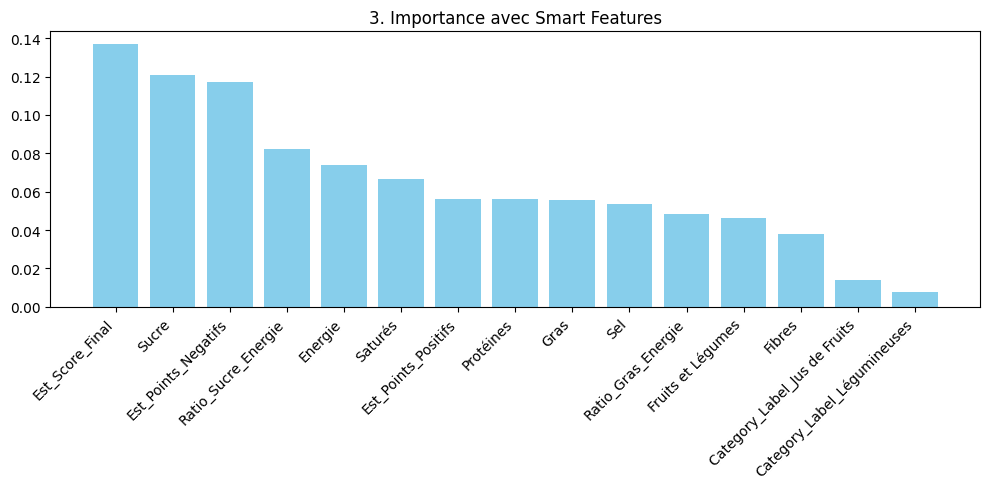

In [12]:
# 3 FEATURE ENGINEERING (Le Game Changer)
print("\n🟩 --- ÉTAPE 3 : AJOUT DES SMART FEATURES ---")
# 1. On injecte les calculs
predictor.add_smart_features()

# 2. On RE-PRÉPARE les données
predictor.prepare_data(include_categorical=True)

# 3. On RE-ENTRAÎNE
predictor.train() 
scores_history['3. Smart Features'] = predictor.evaluate(method="cross_val")

# 📊 VUE 3 : Le modèle a-t-il compris la formule ? (Regarde 'Est_Score_Final')
predictor.plot_feature_importance(top_n=15, custom_title="3. Importance avec Smart Features")


🟧 --- ÉTAPE 4 : TUNING FINAL (SMART) ---
🔧 Optimisation en cours (Patience...)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
🎉 Meilleurs params : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 CV Score : 88.09% (+/- 1.05%)


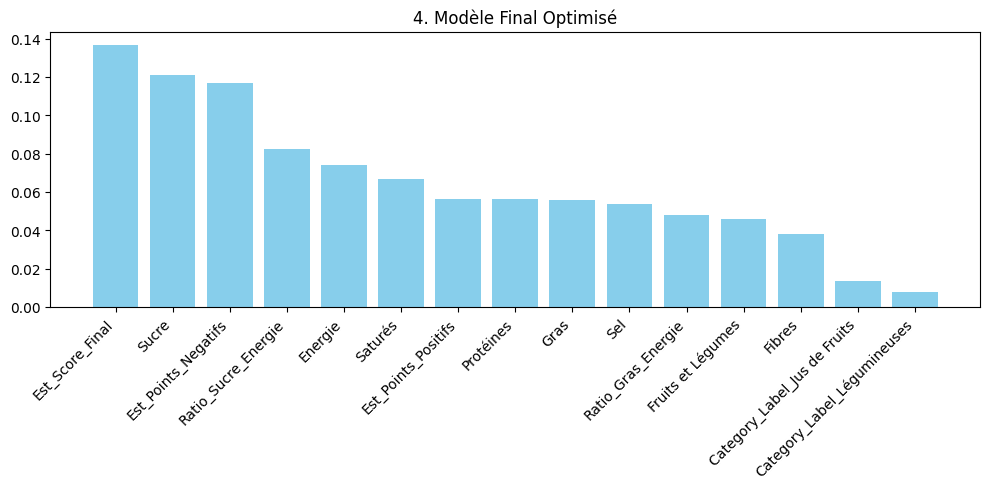

In [13]:

# 4️⃣ HYPERPARAMÈTRES FINAL (Optimisation du modèle Smart)
print("\n🟧 --- ÉTAPE 4 : TUNING FINAL (SMART) ---")
predictor.optimize_hyperparameters()
scores_history['4. Smart Tuned'] = predictor.evaluate(method="cross_val")

# 📊 VUE 4 : Le modèle ultime
predictor.plot_feature_importance(top_n=15, custom_title="4. Modèle Final Optimisé")

**Le résultat est sans appel :**
En nourrissant le modèle avec ces variables "métier", nous sommes passés d'une précision "plafond" à une meilleure compréhension de la logique avec un score bien supérieur.

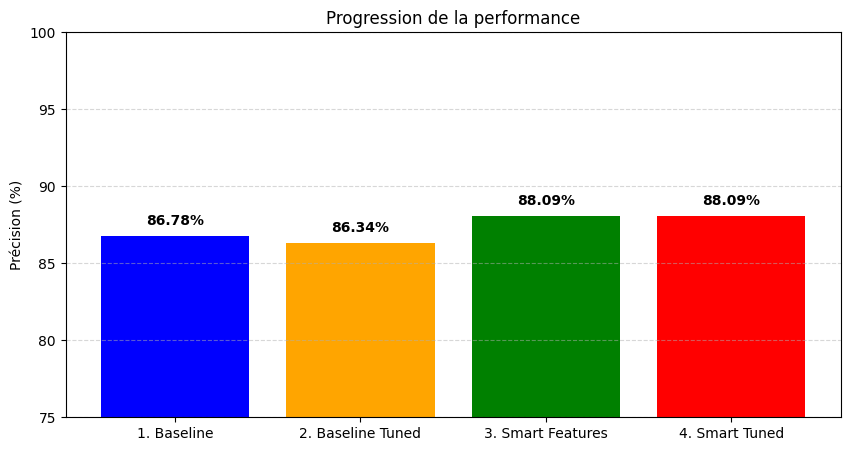

In [14]:
# 🏆 BILAN FINAL

plt.figure(figsize=(10, 5))
bars = plt.bar(scores_history.keys(), [s*100 for s in scores_history.values()], 
               color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Précision (%)')
plt.title('Progression de la performance')
plt.ylim(75, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
             f"{height:.2f}%", ha='center', va='bottom', fontweight='bold')
plt.show()

## 🏁 Conclusion générale du projet

### 📈 Analyse de la Progression des Performances

L'évolution de la précision du modèle démontre l'efficacité de notre approche méthodologique :

* **Baseline (86.78%)** : Le modèle initial présente déjà une excellente performance, confirmant que les données brutes contiennent l'essentiel du signal nécessaire.
* **Hyperparameter Tuning (86.34%)** : Le léger recul montre que les réglages par défaut étaient déjà optimaux pour ce dataset, que le modèle a préféré généraliser, ou que cette étape eut été un peu décevante.
* **Apport du Feature Engineering (88.09%)** : L'introduction des **"Smart Features"** (ratios et estimation du score) a permis de briser le plafond de verre des 87%. L'injection de logique métier est ici plus puissante que la simple optimisation algorithmique.
* **Stabilité Finale** : Le score final de **88.09%** avec un écart-type faible (+/- 1.02%) garantit un modèle robuste et fiable.

### 🧠 Synthèse de l'Intelligence du Modèle

L'analyse de l'importance des variables confirme que le modèle a parfaitement intégré la hiérarchie nutritionnelle :
1.  **Le Sucre** domine largement les prédictions (~20%), suivi des **Graisses Saturées** et du **Sel**.
2.  Le modèle privilégie les **nutriments universels** plutôt que les catégories de produits, assurant une classification basée sur la réalité biologique plutôt que sur le marketing.


**En conclusion, ce projet démontre que l'alliance entre le Machine Learning et l'expertise en nutrition (via le Feature Engineering) permet d'atteindre une précision de près de 90%, offrant un outil d'aide à la décision performant pour l'industrie agroalimentaire et les consommateurs.**